## Imports

In [1]:
import pandas as pd
from pathlib import Path
from simpful.gp_fuzzy_system.gp_evolution import genetic_algorithm_loop
from simpful.gp_fuzzy_system.auto_lvs import FuzzyLinguisticVariableProcessor


/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/new_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Load Data

In [5]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Paths to the prepped data files
base_path = './daily_data/'
X_train_path = base_path + 'X_train.csv'
X_test_path = base_path + 'X_test.csv'
y_train_path = base_path + 'y_train.csv'
y_test_path = base_path + 'y_test.csv'

# Loading the datasets
X_train = pd.read_csv(X_train_path)
X_test = pd.read_csv(X_test_path)
y_train = pd.read_csv(y_train_path)
y_test = pd.read_csv(y_test_path)

# Impute missing values in 'value' and 'classification_numerical' columns
imputer = SimpleImputer(strategy='mean')
X_train[['value', 'classification_numerical']] = imputer.fit_transform(X_train[['value', 'classification_numerical']])

# Verify that there are no NaN values left
print("NaN values in X_train after imputation:\n", X_train.isna().sum().sum())

# Check for extreme values in the data
print("Extreme values in X_train:", (X_train > 1e9).sum().sum())

# Exclude non-numerical columns before scaling
columns_to_scale = X_train.columns  # All columns in X_train are numerical

# Initialize the scaler for the features
scaler_X = MinMaxScaler()

# Scale 'X' features
x_train_scaled = scaler_X.fit_transform(X_train[columns_to_scale])
x_test_scaled = scaler_X.transform(X_test[columns_to_scale])

# Initialize a separate scaler for the target variable
scaler_y = MinMaxScaler()

# Scale 'y' (the target variable)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Save the preprocessed data to temporary CSV files
temp_X_train_path = 'temp_X_train.csv'
temp_y_train_path = 'temp_y_train.csv'
pd.DataFrame(x_train_scaled, columns=columns_to_scale).to_csv(temp_X_train_path, index=False)
pd.DataFrame(y_train_scaled, columns=['target']).to_csv(temp_y_train_path, index=False)


NaN values in X_train after imputation:
 0
Extreme values in X_train: 2367


## Further Processing

In [6]:
def run_genetic_algorithm(x_train_path, y_train_path, terms_dict_path, exclude_columns, population_size, max_generations, mutation_rate, crossover_rate, selection_method, tournament_size, elitism_rate, max_rules, min_rules, verbose):
    # Initialize the FuzzyLinguisticVariableProcessor
    processor = FuzzyLinguisticVariableProcessor(
        file_path=x_train_path,
        terms_dict_path=terms_dict_path, 
        verbose=verbose, 
        exclude_columns=exclude_columns.split(',')
    )
    variable_store = processor.process_dataset()

    # Load the y_train data
    y_train = pd.read_csv(y_train_path).values.flatten()

    # Run the genetic algorithm loop with the provided arguments
    best_system, best_fitness_per_generation = genetic_algorithm_loop(
        population_size=population_size, 
        max_generations=max_generations, 
        x_train=pd.read_csv(x_train_path).values, 
        y_train=y_train, 
        variable_store=variable_store,
        selection_method=selection_method,
        tournament_size=tournament_size,
        crossover_rate=crossover_rate,
        mutation_rate=mutation_rate,
        elitism_rate=elitism_rate,
        max_rules=max_rules,
        min_rules=min_rules,
        verbose=verbose
    )
    
    # Report the best system found
    print("Best system found:")
    print(best_system)
    return best_system, best_fitness_per_generation


In [7]:
# Define the parameters
exclude_columns = 'month,day,hour'
terms_dict_path = './terms/terms_dict.py'
population_size = 10
max_generations = 4
mutation_rate = 0.5
crossover_rate = 0.8
selection_method = 'tournament'
tournament_size = 3
elitism_rate = 0.15
max_rules = 7
min_rules = 3
verbose = True

# Run the genetic algorithm
best_system, best_fitness_per_generation = run_genetic_algorithm(
    temp_X_train_path, temp_y_train_path, terms_dict_path, exclude_columns, 
    population_size, max_generations, mutation_rate, crossover_rate, 
    selection_method, tournament_size, elitism_rate, max_rules, min_rules, verbose
)

# Collect and plot results
fitness_df = pd.DataFrame(best_fitness_per_generation, columns=['Generation', 'Best Fitness'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=fitness_df, x='Generation', y='Best Fitness', marker='o')
plt.title('Best Fitness over Generations')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.grid(True)
plt.savefig('fitness_over_generations.png')
plt.show()


Defined triangular fuzzy set for term 'VERY_LOW' with points: 0.0, 0.021675274499262837, 0.13209202771065726
Defined triangular fuzzy set for term 'LOW' with points: 0.021675274499262837, 0.13209202771065726, 0.4879646461362036
Defined triangular fuzzy set for term 'MEDIUM' with points: 0.13209202771065726, 0.4879646461362036, 0.6605327241208365
Defined triangular fuzzy set for term 'HIGH' with points: 0.4879646461362036, 0.6605327241208365, 0.8616176224328108
Defined triangular fuzzy set for term 'VERY_HIGH' with points: 0.6605327241208365, 0.8616176224328108, 1.0
Created linguistic variable for column 'open' with 5 terms
Defined triangular fuzzy set for term 'VERY_LOW' with points: 0.0, 0.043139785432184136, 0.10533852713160112
Defined triangular fuzzy set for term 'LOW' with points: 0.043139785432184136, 0.10533852713160112, 0.18418587728528432
Defined triangular fuzzy set for term 'MEDIUM' with points: 0.10533852713160112, 0.18418587728528432, 0.3342126069844846
Defined triangular 

Generations:   0%|                                                                                                                                                                                             | 0/4 [00:00<?, ?gen/s]

Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new s

Generations:  25%|█████████████████████████████████████████████                                                                                                                                       | 1/4 [03:11<09:33, 191.24s/gen]

Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new systems.
Refilled backup population with 30 new s

KeyboardInterrupt: 

    Generation  Best Fitness  Average Fitness
0            0      0.652779         3.529664
1            1      0.652779         2.857315
2            2      0.562404         2.434181
3            3      0.381891         2.088151
4            4      0.308809         1.855130
..         ...           ...              ...
95          95      0.290793         0.979263
96          96      0.290793         0.879167
97          97      0.290793         1.005241
98          98      0.290793         0.996290
99          99      0.290793         0.924984

[100 rows x 3 columns]


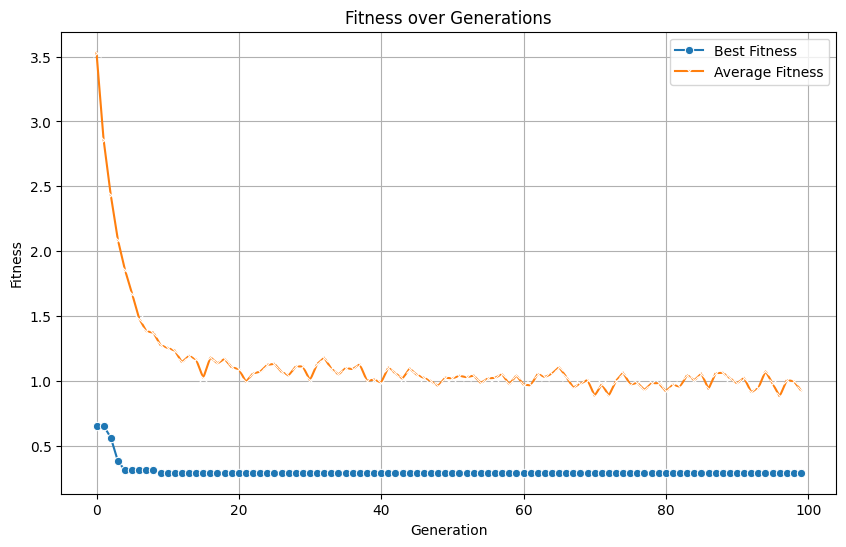

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Merge the DataFrames on 'Generation'
fitness_df = pd.merge(best_fitness_df, average_fitness_df, on='Generation')

# Display the DataFrame as a table
print(fitness_df)

# Plot the data using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=fitness_df, x='Generation', y='Best Fitness', marker='o', label='Best Fitness')
sns.lineplot(data=fitness_df, x='Generation', y='Average Fitness', marker='x', label='Average Fitness')

# Set the title and labels
plt.title('Fitness over Generations')
plt.xlabel('Generation')
plt.ylabel('Fitness')

# Show grid and legend
plt.grid(True)
plt.legend()

# Save the plot to a file
plt.savefig('fitness_over_generations.png')

# Display the plot
plt.show()